In [3]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import earthpy as et
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Spatial subsetting for netcdf files
import regionmask

# Plotting options
sns.set(font_scale = 1.3, style = 'white')

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

# Get the netcdf file
data_path_monthly = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc'
monthly_forecast_temp_xr = xr.open_dataset(data_path_monthly)

# Get the AOI
url = ("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip")
states_gdf = gpd.read_file(url)
states_gdf.head()

c:\Users\Francesco\anaconda3\envs\env\Lib\site-packages\earthpy\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 scale rank,2,AUS-2651,2651,AU-WA,None,AU,6,Western Australia,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((113.13181 -25.95199, 113.14823..."
1,Admin-1 scale rank,2,AUS-2650,2650,AU-NT,None,AU,6,Northern Territory,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((129.00196 -25.99901, 129.00196..."
2,Admin-1 scale rank,2,AUS-2655,2655,AU-SA,None,AU,3,South Australia,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((129.00196 -31.69266, 129.00196..."
3,Admin-1 scale rank,2,AUS-2657,2657,AU-QLD,None,AU,5,Queensland,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((138.00196 -25.99901, 138.00174..."
4,Admin-1 scale rank,2,AUS-2660,2660,AU-TAS,None,AU,5,Tasmania,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((147.31246 -43.28038, 147.34238..."


In [4]:
cali_aoi = states_gdf[states_gdf.name == 'California']
cali_aoi.total_bounds

array([-124.37165376,   32.53336527, -114.12501824,   42.00076797])

In [5]:
# Get lat and lon
aoi_lat = [float(cali_aoi.total_bounds[1]), float(cali_aoi.total_bounds[3])]
aoi_lon = [float(cali_aoi.total_bounds[0]), float(cali_aoi.total_bounds[2])]
aoi_lon[0] = aoi_lon[0] + 360
aoi_lon[1] = aoi_lon[1] + 360
aoi_lat, aoi_lon

([32.533365269889316, 42.00076797479207],
 [235.62834623836392, 245.87498176107795])

In [ ]:
# Slice the data  by time and aoi total  bounds extent
start_date = '2010-01-15'
end_date = '2010-02-15'
two_months_cali = monthly_forecast_temp_xr.sel(time=slice(start_date, end_date),
                                               lon=slice(aoi_lon[0], aoi_lon[1]),
                                               lat=slice(aoi_lat[0], aoi_lat[1]))
two_months_cali

<xarray.Dataset> Size: 451kB
Dimensions:          (time: 2, lat: 227, lon: 246, crs: 1)
Coordinates:
  * time             (time) object 16B 2010-01-15 00:00:00 2010-02-15 00:00:00
  * lat              (lat) float64 2kB 32.56 32.6 32.65 ... 41.9 41.94 41.98
  * lon              (lon) float64 2kB 235.6 235.7 235.7 ... 245.8 245.8 245.9
  * crs              (crs) int32 4B 1
Data variables:
    air_temperature  (time, lat, lon) float32 447kB ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

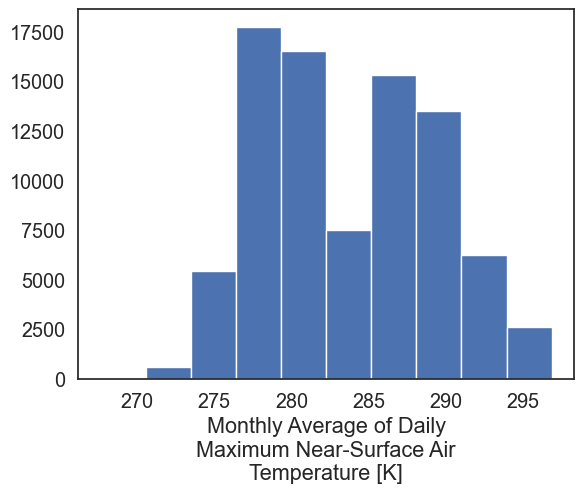

In [8]:
# Plot a quick histogram
two_months_cali['air_temperature'].plot()
plt.show()

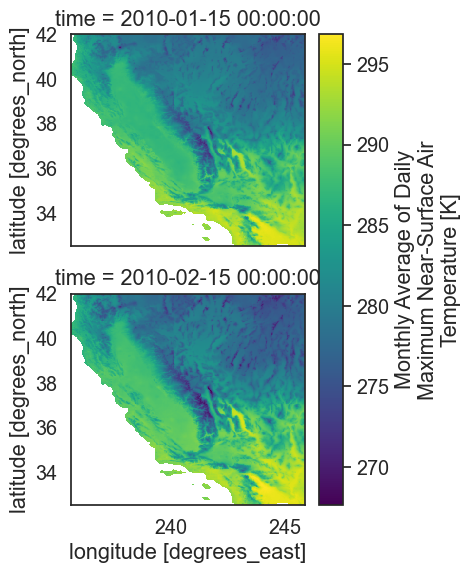

In [10]:
# Spatial plot for the aoi
two_months_cali['air_temperature'].plot(col='time',
                     col_wrap=1)
plt.show()

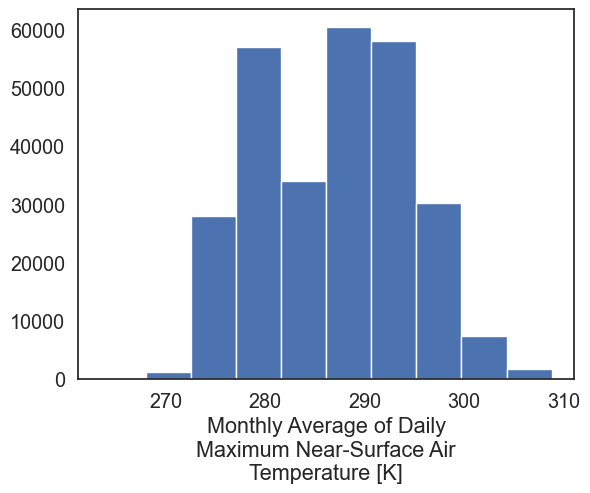

In [41]:
# Entire workflow for files netcdf4 by temporal and spatial extent (multiple regions)

# Function to get the aoi lat/lon extent
def get_aoi(shp, world=True):
    
    lon_lat = {}
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    if world:
        aoi_lon[0] = aoi_lon[0] + 360
        aoi_lon[1] = aoi_lon[1] + 360
    
    lon_lat['lon'] = aoi_lon
    lon_lat['lat'] = aoi_lat
    
    return lon_lat

# Spatial extent
# Select multiple regions
cali_or_wash_nev = states_gdf[states_gdf.name.isin(['California', 'Oregon', 'Washington', 'Nevada'])]
west_bounds = get_aoi(cali_or_wash_nev)

# Create a mask for region, lon, and lat
west_mask = regionmask.mask_3D_geopandas(cali_or_wash_nev,
                                         monthly_forecast_temp_xr.lon,
                                         monthly_forecast_temp_xr.lat)

# Time extent
start_date = '2010-01-15'
end_date = '2010-04-15'

# Data subset
two_months_west_coast = monthly_forecast_temp_xr.sel(time=slice(start_date, end_date),
                                                     lon=slice(west_bounds['lon'][0], west_bounds['lon'][1]),
                                                     lat=slice(west_bounds['lat'][0], west_bounds['lat'][1])).where(west_mask)

# Plot the histogram
two_months_west_coast['air_temperature'].plot()
plt.show()

[]

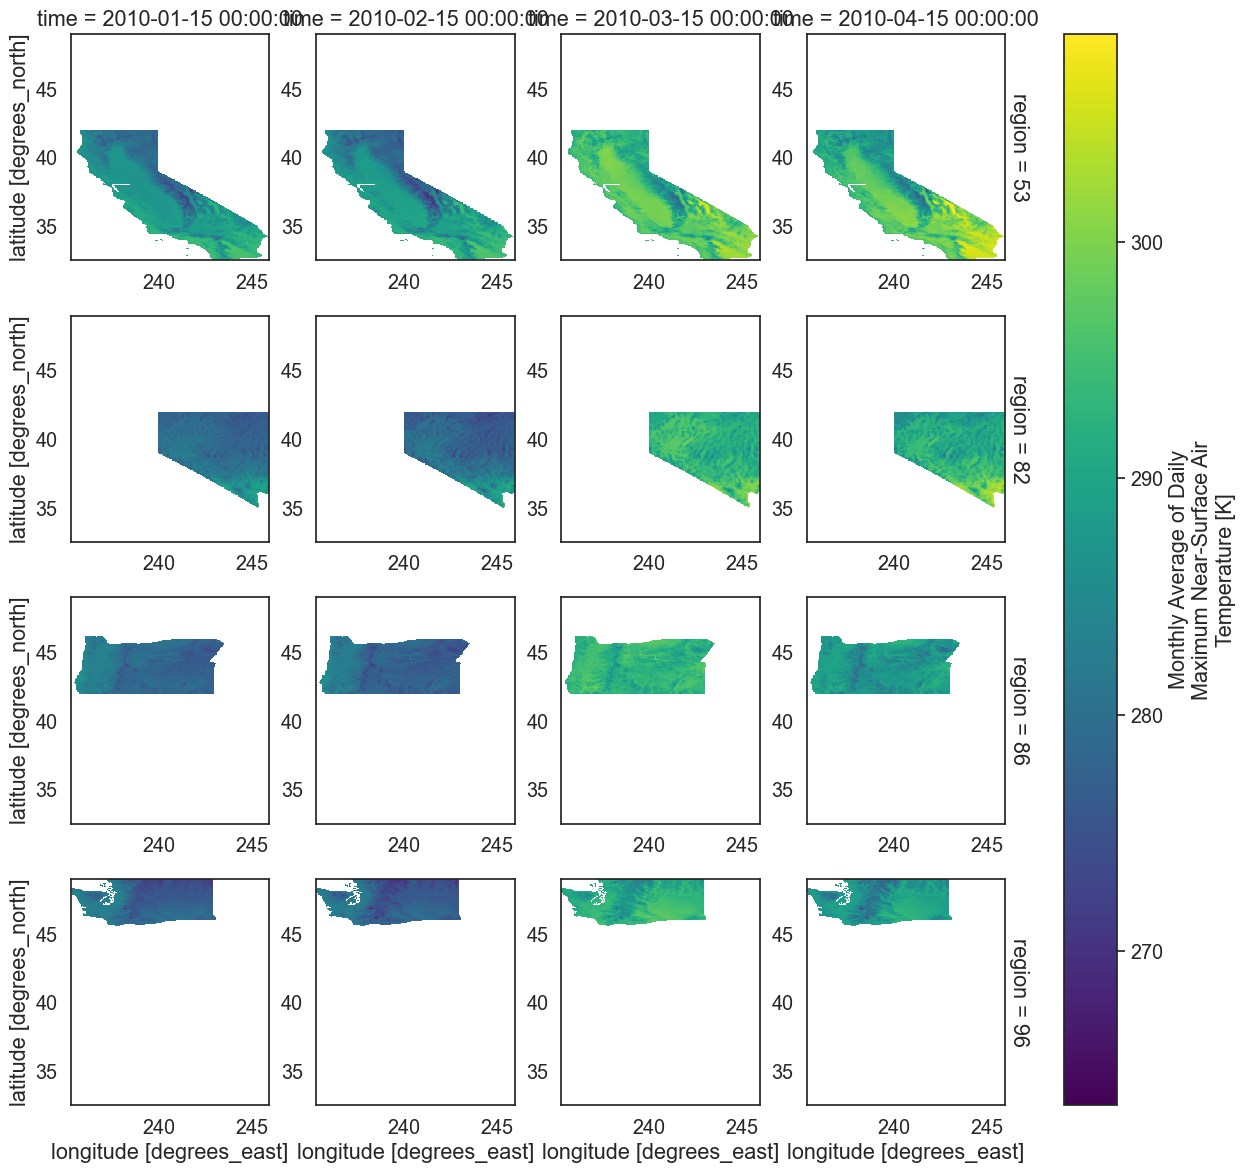

In [42]:
two_months_west_coast['air_temperature'].plot(col='time',
                           row='region',
                           sharey=False, sharex=False)
plt.plot()

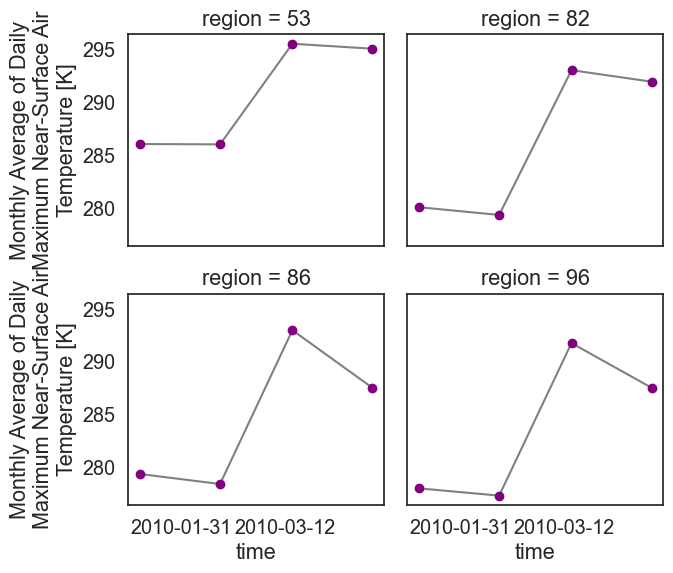

In [ ]:
# Plot the mean data by region
regional_summary = two_months_west_coast.groupby('region').mean(['lat', 'lon'])
regional_summary['air_temperature'].plot(col='region',
                      col_wrap=2,
                      marker='o',
                      color='grey',
                      markerfacecolor='purple',
                      markeredgecolor='purple')
plt.show()

In [47]:
# Export to a dataframe
two_months_west_coast.groupby('region').mean(['lat', 'lon']).to_dataframe()

air_temperature
time                region crs                 
2010-01-15 00:00:00 53     1         286.057983
                    82     1         280.085175
                    86     1         279.390381
                    96     1         278.031158
2010-02-15 00:00:00 53     1         286.026550
                    82     1         279.355438
                    86     1         278.442688
                    96     1         277.346069
2010-03-15 00:00:00 53     1         295.535980
                    82     1         293.039276
                    86     1         292.983093
                    96     1         291.764526
2010-04-15 00:00:00 53     1         295.067596
                    82     1         291.950958
                    86     1         287.533386
                    96     1         287.541840